# Vehicle-agnostic scene processing for information embedding.

Input data: processed vehicle groups from the highD dataset. See dataviz.ipynb for more info.

In [10]:
import h5py
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import os
import seaborn as sns

from rich import print
from sys import platform
from time import time


sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("hls", 8)

def print_bl():
    print("\n")
if platform == 'darwin':
    %matplotlib inline
else:
    %matplotlib widget

In [11]:
if platform == 'darwin':
    dataset_location = "/Users/lmiguelmartinez/Tesis/datasets/highD/groups_historic_1000ms/"
else:
    dataset_location = "/home/lmmartinez/Tesis/datasets/highD/groups_historic_1000ms/"
dataset_index = 46 #between 1 and 60
df_groups = pd.read_csv(dataset_location + str(dataset_index).zfill(2) + "_groups.csv")

In [16]:
class PotentialField:
    '''
    A class that represents the occupation information of a frame - See SceneData in dataviz.py.

    Attributes:
        radius_x, radius_y: semiaxis of the ellipse that is considered around the ego vehicle
        step_x, step_y: space discretization in each axis
        df_group_list: a list of vehicle grups as imported by the function read_groups of read_csv.py
    '''
    def __init__(self, radius_x, radius_y, step_x, step_y, df_group_list):
        self.rx, self.ry = radius_x, radius_y
        self.sx, self.sy = step_x, step_y
        self.df_group_list = df_group_list

        self.num_x = int(2*self.rx / self.sx) + 1
        self.num_y = int(2*self.ry / self.sy) + 1
        self.grid = np.zeros([self.num_y, self.num_x], dtype = np.float32) #x dimension is rows, y dimension is columns
        self.x_pos, self.y_pos = np.linspace(-self.rx, self.rx, self.num_x), np.linspace(-self.ry, self.ry, self.num_y) #x and y interchanged so x is the horizontal dimension, and y is the vertical dimension
        print("Initialized grid of shape: {}".format(self.grid.shape))
    
    def calculate_field(self, inner_group, ego_vehicle):
        '''
        Calculates the value of a potential field associated to an ego vehicle in the context of its group in a particular frame
        
        Parameters:
                None
            Returns:
                A numpy array of size (num_y, num_x) in which each element is the value of the potential field evaluated 
                in the corresponding coordinate of the input linespaces
        '''
        def get_field_value(x, y, a, b, c, k):
            '''
            Calculates the value of a potential field along two linespace inputs: x and y coordinates. 
            See https://stackoverflow.com/a/22778484 for magic around empty dimensions - I still don't understand how, but it works.
            
            Parameters:
                    x, y: linespaces along which the field is calculated. Positions are relative to the vehicle that is being considered, 
                        which is itself relative to the ego vehicle
                    k, a, b, c: parameters of the gaussian - amplitude and exponent coefficients. 
                                The calculation of a, b and c is done from standard deviations and angle of rotation
                Returns:
                    A numpy array of size (num_y, num_x) in which each element is the value of the potential field evaluated 
                    in the corresponding coordinate of the input linespaces
            '''
            local_grid = k * np.exp(-(a * np.square(x[None,:]) + 2 * b * x[None,:] * y[:,None] + c * np.square(y[:,None])))
            return local_grid
        
        def calculate_parameters_and_field_value(ego_vehicle, vehicle):
            '''
            Calculates the parameters of the potential field associated to a particular vehicle in the context of a group.
            Serves as a function call to the apply method of the dataframe that contains the information of the vehicles in the group in a particular frame.
            
            Parameters:
                    ego_vehicle: instance of dataframe that contains the information of the ego vehicle in a particular frame.
                    vehicle: vehicle which field is beign considered
                Returns:
            '''
            x1, y1 = ego_vehicle.x, ego_vehicle.y
            x2, y2, vx2, vy2, w2, h2 = vehicle.x, vehicle.y, vehicle.xVelocity, vehicle.yVelocity, vehicle.width, vehicle.height
            x_rel = x2 - x1
            y_rel = - y2 + y1 #positive y direction points "downwards"
            dx, dy = self.x_pos - x_rel, self.y_pos - y_rel
            ang = np.arctan2(vx2, vy2)
            sigma_y, sigma_x = w2, h2/2
            a = np.square(np.cos(ang)) / (2 * np.square(sigma_x)) + np.square(np.sin(ang)) / (2 * np.square(sigma_y))
            b = - np.sin(2 * ang) / (4 * np.square(sigma_x)) + np.sin(2 * ang) / (4 * np.square(sigma_y))
            c = np.square(np.sin(ang)) / (2 * np.square(sigma_x)) + np.square(np.cos(ang)) / (2 * np.square(sigma_y))
            k = np.linalg.norm((vehicle.xVelocity, vehicle.yVelocity))
            grid = get_field_value(dx, dy, a, b, c, k)
            return grid

        grid = np.zeros([self.num_y, self.num_x], dtype = np.float32) #x dimension is rows, y dimension is columns
        for _, row in inner_group.iterrows():
            grid = np.add(grid, calculate_parameters_and_field_value(ego_vehicle=ego_vehicle, vehicle=row))

        return grid
    
    def calculate_field_list(self):
        '''
        Performs potential field calculations for every group in df_group_list
        
        Parameters:
                None
            Returns:
                An np.array in which each element is the potential field representation of the associated group.
        '''
        self.field_list = []
        for idx, (_, group) in enumerate(self.df_group_list.groupby("historical_aggregation_index")):
            if not (idx%100):
                print("Processing group {} of {}".format(idx, self.df_group_list["historical_aggregation_index"].nunique()))
            group["frame"] = - group["frame"] + group["frame"].max() + 1 # determine relative frame step to atenuate distant values
            #Current frame will have a value of 1, previous frame will have a value of 2, nth frame will have a value of n
            ego_vehicle_id = group.iloc[0].id
            temp_grid = np.zeros([self.num_y, self.num_x], dtype = np.float32) #x dimension is rows, y dimension is columns
            for frame_number, inner_group in group.groupby("frame"): #add the field for every frame
                frame_attenuation = np.exp(-0.65*(inner_group.iloc[0].frame -1))
                ego_vehicle = inner_group[inner_group["id"] == ego_vehicle_id].iloc[0]
                temp_grid = np.add(self.calculate_field(inner_group, ego_vehicle) * frame_attenuation, temp_grid)
            self.field_list.append(temp_grid)
        self.field_list = np.asarray(self.field_list)

        return self.field_list
    
    def save_to_hdf5(self, train_ratio, val_ratio, hdf5_file):
        """
        Split a list of NumPy arrays into train, validation, and test datasets and save them to an HDF5 file.

        :param image_list: List of NumPy arrays (images).
        :param train_ratio: Ratio of data to allocate for training (e.g., 0.7 for 70%).
        :param val_ratio: Ratio of data to allocate for validation (e.g., 0.15 for 15%).
        :param hdf5_file: Name of the HDF5 file to save the datasets.
        """
        if train_ratio + val_ratio >= 1.0:
            raise ValueError("The sum of train_ratio and val_ratio should be less than 1.0.")
        
        total_samples = len(self.field_list)
        train_size = int(total_samples * train_ratio)
        val_size = int(total_samples * val_ratio)

        #np.random.shuffle(field_list)
        # Split the data into train, validation, and test sets
        train_data = self.field_list[:train_size]
        val_data = self.field_list[train_size:train_size + val_size]
        test_data = self.field_list[train_size + val_size:]

        #reescale the images for saving
        train_max, train_min = np.max(train_data), np.min(train_data)

        train_data  = 255 * (train_data - train_min) / (train_max - train_min)
        val_data  = 255 * (val_data - train_min) / (train_max - train_min)
        test_data  = 255 * (test_data - train_min) / (train_max - train_min)

        train_data = train_data.astype(np.uint8)
        val_data = val_data.astype(np.uint8)
        test_data = test_data.astype(np.uint8)
        metadata = {'train_max': train_max, 'train_min': train_min}

        # Save the datasets to an HDF5 file
        with h5py.File(hdf5_file, "w") as hf:
            hf.create_dataset("train", data=train_data)
            hf.create_dataset("validation", data=val_data)
            hf.create_dataset("test", data=test_data)
            for key, value in metadata.items():
                hf.attrs[key] = value
        
    def plot_field(self, idx = None):
        '''
        Plots a 3d graph and a heat map of the potential field of a given group in the variable idx.
        
        Parameters:
                idx: index of the group that will be represented
            Returns:
                None
        '''
        if idx is None:
            idx = np.random.randint(len(self.field_list))
        fig = plt.figure(figsize=(15, 8))

        #plot 3d field
        ax3d = fig.add_subplot(1, 2, 1, projection='3d')
        X, Y = np.meshgrid(self.x_pos, self.y_pos)
        surf = ax3d.plot_surface(X, Y, self.field_list[idx], cmap = "viridis")
        ax3d.set_xlabel("Longitudinal axis (m)")
        ax3d.set_ylabel("Transversal axis (m)")
        ax3d.set_zlabel("Potential field magnitude (-)")
        ax3d.set_title("3d plot - Normalized between 0 and 1")
        fig.colorbar(surf, orientation = 'horizontal', pad = 0.2)

        #plot heatmap
        ax2d = fig.add_subplot(1, 2, 2)
        img = ax2d.imshow(self.field_list[idx])
        ax2d.set_xlabel("Longitudinal axis (px)")
        ax2d.set_ylabel("Transversal axis (px)")
        ax2d.set_title("Potential field heat map")
        fig.colorbar(img, orientation = 'horizontal', pad = 0.2)

        fig.suptitle(f"Potential field representation - Frame {idx}")
        plt.show()

    def plot_center_field(self, idx):
        '''
        Plots the value of the potential field in the longitudinal axis of the ego vehicle of a given group in the variable idx.
        
        Parameters:
                idx: index of the group that will be represented
            Returns:
                None
        '''
        if idx is None:
            idx = np.random.randint(len(self.field_list))
        fig, ax = plt.subplots()
        y_index = int((self.field_list[idx].shape[0] - 1) / 2)
        x = self.x_pos
        y = self.self.field_list[idx][y_index]
        ax.plot(x, y)
        ax.set_xlabel("Transversal axis (m)")
        ax.set_ylabel("Potential field magnitude (-)")
        ax.set_title(f"Ego longitudinal x axis - Frame {idx}")

        plt.show()

    def plot_heat_map(self, idx):
        '''
        Plots the heat map of the potential field of a given group in the variable idx.
        
        Parameters:
                idx: index of the group that will be represented
            Returns:
                None
        '''
        if idx is None:
            idx = np.random.randint(len(self.field_list))
        fig, ax = plt.subplots()
        ax.imshow(self.field_list[idx])
        ax.set_xlabel("Longitudinal axis (m)")
        ax.set_ylabel("Transversal axis (m)")
        ax.set_title(f"Potential field heat map - Frame {idx}")
        plt.show()

In [17]:
rx = 50 # horizontal semiaxis of ellipse to consider as ROI
ry = 6 # vertical semiaxis of ellipse to consider as ROI
sx = 0.5
sy = 0.1
df_groups.groupby("historical_aggregation_index").get_group(7).head(-1)

,Index,frame,id,x,y,width,height,xVelocity,yVelocity,xAcceleration,...,followingId,leftPrecedingId,leftAlongsideId,leftFollowingId,rightPrecedingId,rightAlongsideId,rightFollowingId,laneId,drivingDirection,historical_aggregation_index
299,2487,0,20,313.29,26.87,4.45,1.92,8.96,0.09,0.67,...,26,12,0,18,15,23,25,7,East,7
300,572,0,9,357.30,21.52,5.15,2.50,11.95,0.18,0.15,...,12,0,0,0,2,10,14,6,East,7
301,686,0,10,355.13,27.29,5.05,1.92,9.49,-0.00,0.39,...,14,5,9,12,6,15,23,7,East,7
302,941,0,12,330.89,23.17,4.14,1.82,11.84,0.18,0.62,...,18,0,0,0,14,0,20,6,East,7
303,1272,0,14,339.56,26.64,5.15,2.02,9.48,-0.00,0.39,...,20,9,0,12,6,15,23,7,East,7
304,1430,0,15,338.85,31.40,17.79,2.50,7.72,-0.09,0.32,...,23,2,14,20,0,0,0,8,East,7
305,2043,0,18,305.73,22.07,5.05,2.02,11.19,-0.08,0.02,...,22,0,0,0,20,0,26,6,East,7
306,3000,0,22,277.91,22.34,5.26,2.02,7.74,-0.09,0.65,...,27,0,0,0,20,26,28,6,East,7
307,3288,0,23,307.21,30.74,17.38,2.50,7.54,-0.00,0.08,...,25,14,20,26,0,0,0,8,East,7
308,3841,0,25,290.53,31.43,4.45,1.82,8.17,0.00,0.00,...,30,20,0,26,0,0,0,8,East,7


In [18]:
start = time()
field = PotentialField(rx, ry, sx, sy, df_groups[df_groups["historical_aggregation_index"] >= 59])
field_list = field.calculate_field_list()
end = time()
print("Time taken is {}".format(end-start))

Initialized grid of shape: (121, 201)

Processing group 0 of 2469

Processing group 100 of 2469

Processing group 200 of 2469

Processing group 300 of 2469

Processing group 400 of 2469

Processing group 500 of 2469

Processing group 600 of 2469

Processing group 700 of 2469

Processing group 800 of 2469

Processing group 900 of 2469

Processing group 1000 of 2469

Processing group 1100 of 2469

Processing group 1200 of 2469

Processing group 1300 of 2469

Processing group 1400 of 2469

Processing group 1500 of 2469

Processing group 1600 of 2469

Processing group 1700 of 2469

Processing group 1800 of 2469

Processing group 1900 of 2469

Processing group 2000 of 2469

Processing group 2100 of 2469

Processing group 2200 of 2469

Processing group 2300 of 2469

Processing group 2400 of 2469

Time taken is 17.45389199256897

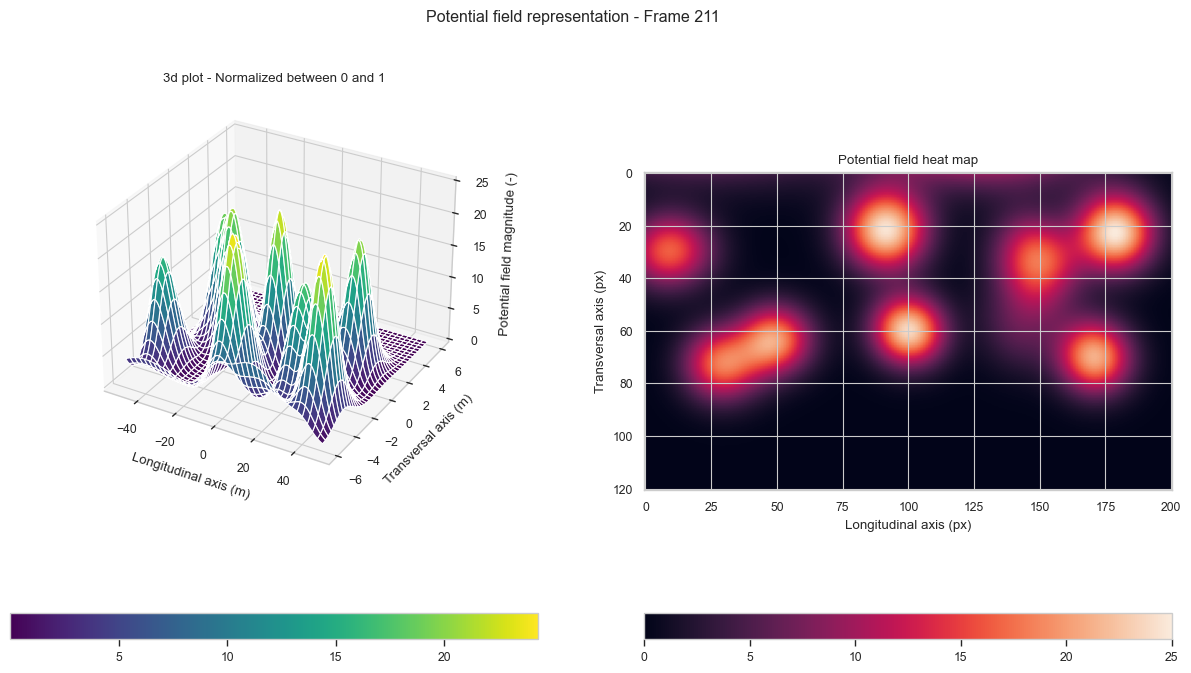

In [20]:
field.plot_field()

In [7]:
plt.close('all')